# Bitcoin Prediction based on Tweets Sentiments

#### Importing packages

In [ ]:
#Import libraries
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mp
#import pandas_profiling as pp
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show, figure
import warnings    # Ignore warning related to pandas_profiling
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)   # Display all dataframe columns in outputs
pd.options.display.min_rows = 150
pd.options.display.float_format = '{:,.5f}'.format
from sklearn.metrics import mean_squared_error,mean_absolute_error , mean_absolute_percentage_error
import math

#### Importing the Dataset

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',  force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/FinalThesis/Final_Data

/content/gdrive/MyDrive/FinalThesis/Final_Data


### 3. Data Profiling <a id=section3></a>

### 3.1. Understanding the Dataset <a id=section301></a>

#### 3.1.1. Price Datset

In [ ]:
data = pd.read_csv("finbert_bitcoin_merged.csv")
data['date'] = pd.to_datetime(data['date'])

In [ ]:
#data.drop(data.index[0:4], inplace=True)
data.head()

,date,close,compound_score
0,2021-02-01,"33,537.17578",0.00000
1,2021-02-02,"35,510.28906",0.00000
2,2021-02-03,"37,472.08984",0.00000
3,2021-02-04,"36,926.06641",0.00000
4,2021-02-05,"38,144.30859",0.03670


#### 3.3.1. Price Datset

Converting Date column from object to DateTime

In [ ]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(numeric_columns)
data[numeric_columns.columns] = scaler.transform(numeric_columns)


In [ ]:
data.head()

,date,close,compound_score
0,2021-02-01,0.11069,0.01198
1,2021-02-02,0.16925,0.01198
2,2021-02-03,0.22747,0.01198
3,2021-02-04,0.21126,0.01198
4,2021-02-05,0.24742,0.37824


In [ ]:
data.index = data['date']

In [ ]:
df = data.drop('date', axis = 1)

In [ ]:
df = df [['close', 'compound_score']]

In [ ]:
df.columns = ['close_price','sentiment_score']

In [ ]:
df.describe()

,close_price,sentiment_score
count,212.00000,212.00000
mean,0.47573,0.18899
std,0.27876,0.29012
min,0.00000,0.00000
25%,0.21296,0.01198
50%,0.50248,0.01198
75%,0.74399,0.36178
max,1.00000,1.00000


In [ ]:
df = df.dropna()


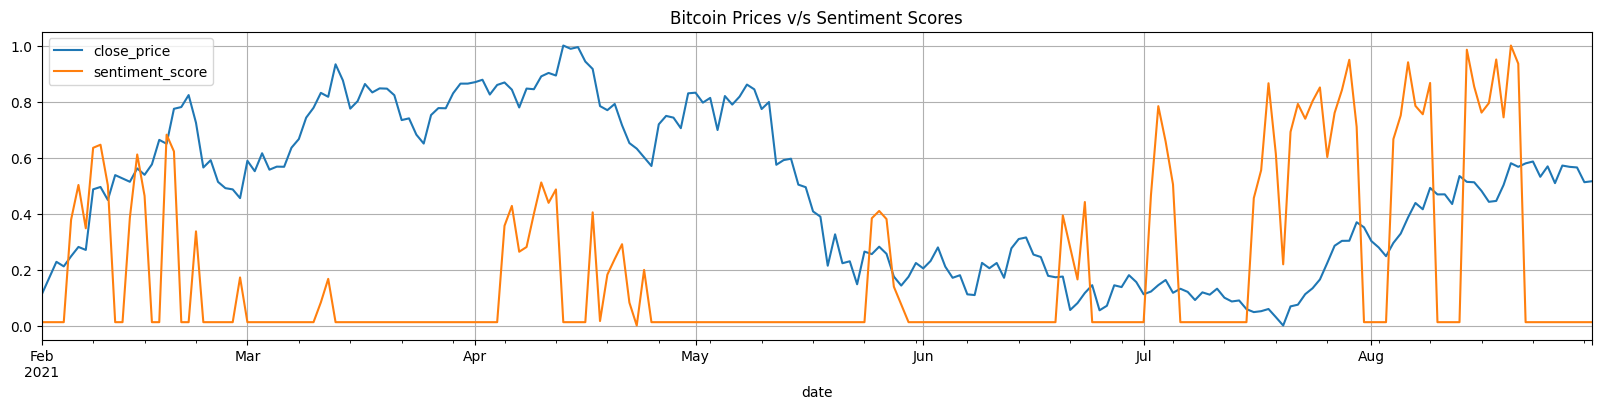

In [ ]:
df[['close_price','sentiment_score']].plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('Bitcoin Prices v/s Sentiment Scores')
plt.show(block=False)

# **ADF (Augmented Dickey-Fuller) TEST**

ADF test is conducted with the following assumptions:

**Null Hypothesis (HO):** Series is non-stationary, or series has a unit root.

**Alternate Hypothesis(HA):** Series is stationary, or series has no unit root.
If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

Conditions to Reject Null Hypothesis(HO) **bold text**

If **Test statistic < Critical Value** and **p-value < 0.05** – Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.

In [ ]:
# Load Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
adfuller??

In [ ]:
price_data = df['close_price']
score_data = df['sentiment_score']

In [ ]:
price_data.head()

date
2021-02-01   0.11069
2021-02-02   0.16925
2021-02-03   0.22747
2021-02-04   0.21126
2021-02-05   0.24742
Name: close_price, dtype: float64

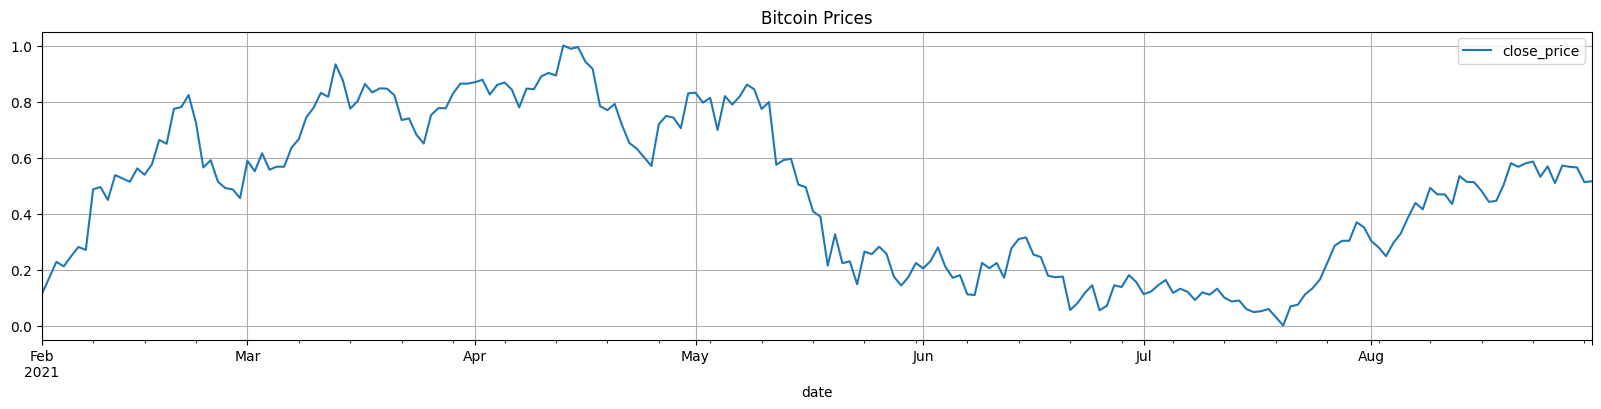

In [ ]:
price_data.plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('Bitcoin Prices')
plt.show(block=False)

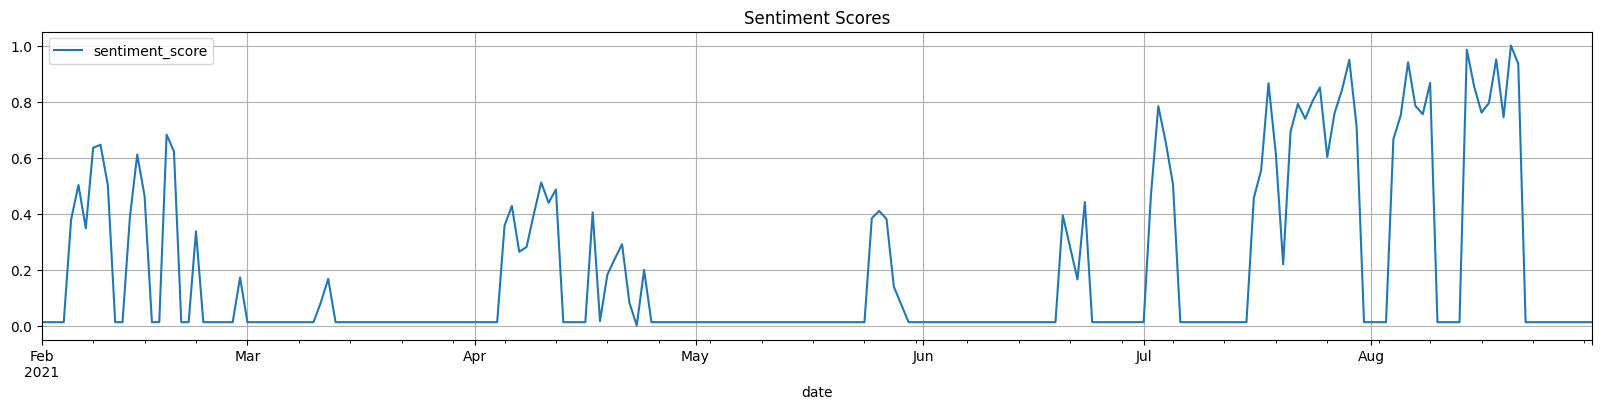

In [ ]:
score_data.plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('Sentiment Scores')
plt.show(block=False)

In [ ]:
#Function to print out results in customised manner

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
# Call the function and run the test
adf_test(price_data)

Results of Dickey-Fuller Test:
Test Statistic                 -1.63187
p-value                         0.46651
#Lags Used                      2.00000
Number of Observations Used   209.00000
Critical Value (1%)            -3.46203
Critical Value (5%)            -2.87547
Critical Value (10%)           -2.57420
dtype: float64


In [ ]:
adf_test(score_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.53710
p-value                         0.10671
#Lags Used                      8.00000
Number of Observations Used   203.00000
Critical Value (1%)            -3.46298
Critical Value (5%)            -2.87589
Critical Value (10%)           -2.57442
dtype: float64


### *Result of ADF Test:* As the below conditions are not fulfilled, there is no reason to reject the null hypotheses that is we fail to reject the null hypotheses. So, the time series is non-stationary.

- Test Statictic (-1.67 )  > Critical Value (5%) (-2.87)
- AND
- p-value (0.46) > 0.05

#KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

The KPSS test is conducted with the following assumptions.

**Null Hypothesis (HO):** Series is trend stationary or series has no unit root.

**Alternate Hypothesis(HA):** Series is non-stationary, or series has a unit root.
Note: The hypothesis is reversed in the KPSS test compared to ADF Test.

If the null hypothesis is failed to be rejected, this test may provide evidence that the series is trend stationary.

**Conditions to Fail to Reject Null Hypothesis(HO)**

If **the Test Statistic < Critical Value and p-value < 0.0**5 – Fail to Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is trend stationary.



In [ ]:
#Function to print out results in customised manner

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='ct',nlags =5)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# Call the function and run the test


In [ ]:
kpss_test(price_data)

Results of KPSS Test:
Test Statistic          0.39376
p-value                 0.01000
#Lags Used              5.00000
Critical Value (10%)    0.11900
Critical Value (5%)     0.14600
Critical Value (2.5%)   0.17600
Critical Value (1%)     0.21600
dtype: float64


In [ ]:
kpss_test(score_data)

Results of KPSS Test:
Test Statistic          0.25661
p-value                 0.01000
#Lags Used              5.00000
Critical Value (10%)    0.11900
Critical Value (5%)     0.14600
Critical Value (2.5%)   0.17600
Critical Value (1%)     0.21600
dtype: float64


### *Result of KPSS Test:* As the on eof the conditions is not fulfilled,  we reject the null hypothese in favor of an Alternative. So, the time series is non-stationary.

- Test Statictic (0.93)  > Critical Value (5%) (0.46)
- p-value (0.01) < 0.05

When to Choose ADF or KPSS Test?

There could be a lot of confusion on when one should use the ADF test or KPSS test and which test would give a correct result. A better solution is to apply/run both tests and makes sure that the series is truly stationary.

The following are the possible outcomes of applying both tests.

- **Case 1:** Both tests conclude that the given series is stationary – The series is stationary
- **Case 2**: Both tests conclude that the given series is non-stationary – The series is non-stationary
- **Case 3:** ADF concludes non-stationary, and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
- **Case 4:** ADF concludes stationary, and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

How unit-root test and stationarity-test complement each other

If you have a time series data set how it usually appears in econometric time series I propose you should apply both a Unit root test: (Augmented) Dickey Fuller or Phillips-Perron depending on the structure of the underlying data and a KPSS test.

Case 1 Unit root test: you can’t reject H0
; KPSS test: reject H0
. Both imply that series has unit root.

Case 2 Unit root test: Reject H0
. KPSS test: don't reject H0
. Both imply that series is stationary.

Case 3 If we can’t reject both test: data give not enough observations.

Case 4 Reject unit root, reject stationarity: both hypotheses are component hypotheses – heteroskedasticity in a series may make a big difference; if there is structural break it will affect inference.

#Detrending by Differencing

In [ ]:
#df_log=np.sqrt(df['Close'])
df['price_diff']=price_data.diff().diff()
df['score_diff']=score_data.diff()

In [ ]:
df_final = df.dropna()
df_final.head()

,close_price,sentiment_score,price_diff,score_diff
date,,,,
2021-02-03,0.22747,0.01198,-0.00034,0.00000
2021-02-04,0.21126,0.01198,-0.07442,0.00000
2021-02-05,0.24742,0.37824,0.05236,0.36627
2021-02-06,0.28070,0.50200,-0.00286,0.12375
2021-02-07,0.26994,0.34731,-0.04405,-0.15469


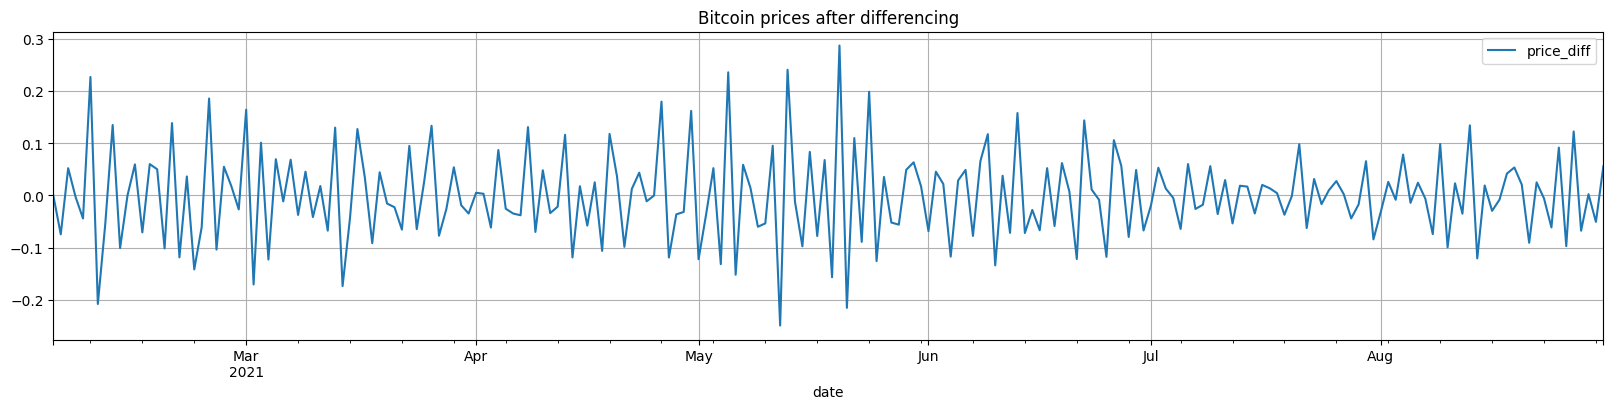

In [ ]:
df_final['price_diff'].plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('Bitcoin prices after differencing')
plt.show(block=False)

In [ ]:
adf_test(df_final['price_diff'])

Results of Dickey-Fuller Test:
Test Statistic                 -6.36669
p-value                         0.00000
#Lags Used                     11.00000
Number of Observations Used   198.00000
Critical Value (1%)            -3.46382
Critical Value (5%)            -2.87625
Critical Value (10%)           -2.57461
dtype: float64


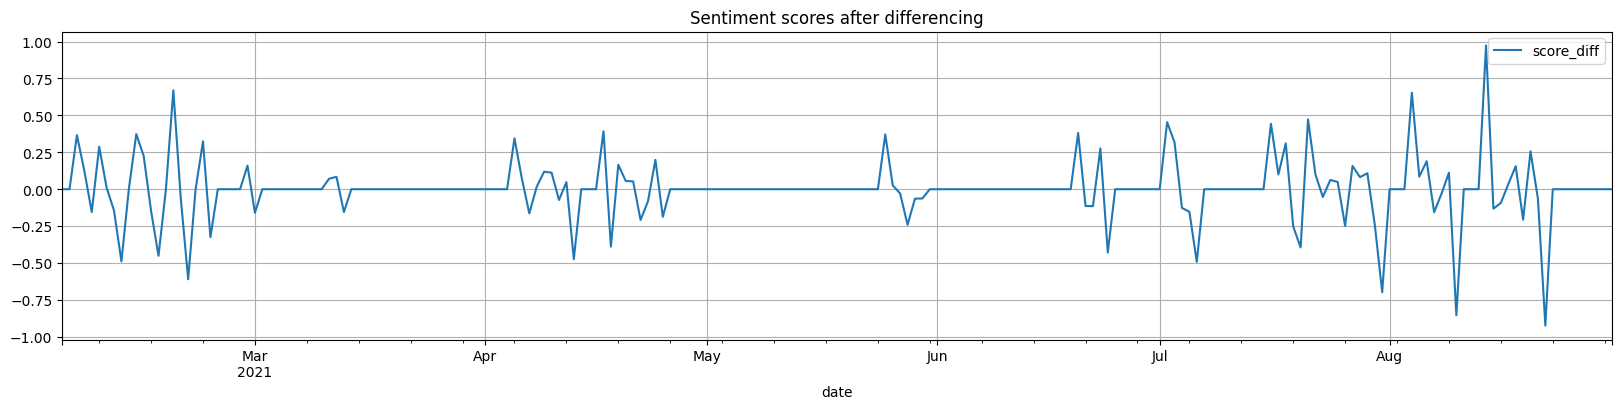

In [ ]:
df_final['score_diff'].plot(figsize=(20, 4))
plt.grid()
plt.legend(loc='best')
plt.title('Sentiment scores after differencing')
plt.show(block=False)

In [ ]:
adf_test(df_final['score_diff'])

Results of Dickey-Fuller Test:
Test Statistic                 -8.87180
p-value                         0.00000
#Lags Used                      7.00000
Number of Observations Used   202.00000
Critical Value (1%)            -3.46314
Critical Value (5%)            -2.87596
Critical Value (10%)           -2.57445
dtype: float64


### *Result of ADF Test:* As the below conditions are fulfilled, we reject the null hypotheses in favour of alternative hypotheses. So, the time series is stationary.

- Test Statictic (-9.734568e+00)  < Critical Value (5%) (-2.875471e+00)
- AND
- p-value (8.820323e-17) < 0.05

In [ ]:
kpss_test(df_final['price_diff'])

Results of KPSS Test:
Test Statistic          0.01505
p-value                 0.10000
#Lags Used              5.00000
Critical Value (10%)    0.11900
Critical Value (5%)     0.14600
Critical Value (2.5%)   0.17600
Critical Value (1%)     0.21600
dtype: float64


In [ ]:
kpss_test(df_final['score_diff'])

Results of KPSS Test:
Test Statistic          0.02250
p-value                 0.10000
#Lags Used              5.00000
Critical Value (10%)    0.11900
Critical Value (5%)     0.14600
Critical Value (2.5%)   0.17600
Critical Value (1%)     0.21600
dtype: float64


Granger Casaulity Test

In [ ]:
corr_matrix = df_final.corr()
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
                 close_price  sentiment_score  price_diff  score_diff
close_price          1.00000         -0.18413     0.01997    -0.04112
sentiment_score     -0.18413          1.00000    -0.01832     0.35190
price_diff           0.01997         -0.01832     1.00000     0.00819
score_diff          -0.04112          0.35190     0.00819     1.00000


In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau

x = df_final['price_diff']
y = df_final['score_diff']

pearson_coef, _ = pearsonr(x, y)
print("Pearson correlation coefficient:", pearson_coef)

spearman_coef, _ = spearmanr(x, y)
print("Spearman correlation coefficient:", spearman_coef)

kendall_coef, _ = kendalltau(x, y)
print("Kendall correlation coefficient:", kendall_coef)

Pearson correlation coefficient: 0.008187594313583443
Spearman correlation coefficient: 0.016389594374033346
Kendall correlation coefficient: 0.014941705550522388


In [ ]:
# perform ADF and KPSS on above time series AND THEN perform GC tests
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
df_gc = df_final[['price_diff','score_diff']]

In [ ]:
df_gc.head()

,price_diff,score_diff
date,,
2021-02-03,-0.00034,0.00000
2021-02-04,-0.07442,0.00000
2021-02-05,0.05236,0.36627
2021-02-06,-0.00286,0.12375
2021-02-07,-0.04405,-0.15469


In [ ]:
gc_res = grangercausalitytests(df_gc, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5086  , p=0.4765  , df_denom=206, df_num=1
ssr based chi2 test:   chi2=0.5161  , p=0.4725  , df=1
likelihood ratio test: chi2=0.5154  , p=0.4728  , df=1
parameter F test:         F=0.5086  , p=0.4765  , df_denom=206, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0604  , p=0.9414  , df_denom=203, df_num=2
ssr based chi2 test:   chi2=0.1237  , p=0.9400  , df=2
likelihood ratio test: chi2=0.1237  , p=0.9400  , df=2
parameter F test:         F=0.0604  , p=0.9414  , df_denom=203, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2964  , p=0.8280  , df_denom=200, df_num=3
ssr based chi2 test:   chi2=0.9202  , p=0.8206  , df=3
likelihood ratio test: chi2=0.9181  , p=0.8210  , df=3
parameter F test:         F=0.2964  , p=0.8280  , df_denom=200, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5628  , p=0.6899  

In [ ]:
ar_df = df_final[['price_diff',	'score_diff']]

In [ ]:
ar_df = ar_df.dropna()
ar_df.shape

(210, 2)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(ar_df)

In [ ]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.227      -8.193   0.0002674      -8.213
1       -8.700      -8.597   0.0001666      -8.658
2       -8.790     -8.619*   0.0001522      -8.721
3       -8.818      -8.579   0.0001480      -8.722
4       -8.896      -8.589   0.0001369     -8.772*
5       -8.873      -8.497   0.0001401      -8.721
6       -8.884      -8.440   0.0001386      -8.704
7       -8.853      -8.340   0.0001431      -8.645
8       -8.940      -8.359   0.0001312      -8.705
9       -8.970      -8.320   0.0001274      -8.707
10      -8.964      -8.246   0.0001281      -8.674
11      -8.968      -8.182   0.0001277      -8.650
12     -8.981*      -8.126  0.0001262*      -8.635
13      -8.945      -8.022   0.0001309      -8.571
14      -8.912      -7.921   0.0001354      -8.511
15      -8.883      -7.823   0.0001396      -8.454
16      -8.859      -7.731   0.

In [ ]:
param = dict(p= range(0, 5),
             q = range(1, 5),
            )

In [ ]:
def get_VARMA_prediction(train_data):
  params_evaluated = []
  for p in param['p']:
    for q in param['q']:
          model = VARMAX(endog = train_data[:-10], order= (p, q))
          results = model.fit(disp=False)
          predictions = results.forecast(10)
          predictions.columns=['price_predicted','score_predicted']
          MSE = mean_squared_error(train_data['price_diff'][-10:], predictions['price_predicted'])
          RMSE = math.sqrt(MSE)
          MAE = mean_absolute_error(train_data['price_diff'][-10:], predictions['price_predicted'])
          MAPE = mean_absolute_percentage_error(train_data['price_diff'][-10:], predictions['price_predicted'])
          params_evaluated.append({'lag': p , 'ma' :q, 'mse': MSE, 'rmse': RMSE, 'mae': MAE, 'mape': MAPE})
  return params_evaluated

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pred_with_sent = get_VARMA_prediction(ar_df)

In [ ]:
eval_metrics = pd.DataFrame(list(pred_with_sent))
eval_metrics

,lag,ma,mse,rmse,mae,mape
0,0,1,0.00471,0.06860,0.05650,0.93854
1,0,2,0.00479,0.06922,0.05853,1.04177
2,0,3,0.00472,0.06874,0.05659,1.03653
3,0,4,0.00452,0.06722,0.05567,1.25628
4,1,1,0.00473,0.06874,0.05663,0.86637
5,1,2,0.00506,0.07115,0.06008,1.09613
6,1,3,0.00512,0.07159,0.06003,1.03652
7,1,4,0.00338,0.05814,0.04798,1.11184
8,2,1,0.00484,0.06959,0.05758,0.91785
9,2,2,0.00532,0.07291,0.06204,1.24925


In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(gap=0, test_size=10, n_splits=n_splits)


mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
# Iterate over train-test splits and train models
for train_index, test_index in tscv.split(ar_df):
    train_data, test_data = ar_df.iloc[train_index], ar_df.iloc[test_index]

    model = VARMAX(endog = train_data, order= (1, 4))
    fitted_model = model.fit(disp=False)

    # Make predictions
    predictions = fitted_model.forecast(steps=len(test_data))
    predictions.columns=['price_predicted','score_predicted']

    # Calculate Mean Squared Error
    MSE = mean_squared_error(test_data['price_diff'], predictions['price_predicted'])
    RMSE = math.sqrt(MSE)
    MAE = mean_absolute_error(test_data['price_diff'], predictions['price_predicted'])
    MAPE = mean_absolute_percentage_error(test_data['price_diff'], predictions['price_predicted'])
    mse_scores.append(MSE)
    rmse_scores.append(RMSE)
    mae_scores.append(MAE)
    mape_scores.append(MAPE)
# Calculate average Mean Squared Error across all splits
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error across all splits: {average_mse}')

average_rmse = np.mean(rmse_scores)
print(f'Average Root Mean Squared Error across all splits: {average_rmse}')

average_mae = np.mean(mae_scores)
print(f'Average Mean Absolute Error across all splits: {average_mae}')

average_mape = np.mean(mape_scores)
print(f'Average Mean Absolute Percentage Error across all splits: {average_mape}')

Average Mean Squared Error across all splits: 0.003782650696030573
Average Root Mean Squared Error across all splits: 0.05832333007629725
Average Mean Absolute Error across all splits: 0.04475518600549309
Average Mean Absolute Percentage Error across all splits: 1.153005130089758


In [ ]:
eval_data = pd.DataFrame(data = {'MSE': mse_scores, 'RMSE': rmse_scores, 'MAE': mae_scores, 'MAPE': mape_scores}, index=np.arange(1, 6))
eval_data.head()

,MSE,RMSE,MAE,MAPE
1,0.00167,0.04090,0.02795,0.94756
2,0.00192,0.04377,0.03772,1.69676
3,0.00286,0.05353,0.03682,0.62618
4,0.00908,0.09529,0.07330,1.38268
5,0.00338,0.05814,0.04798,1.11184


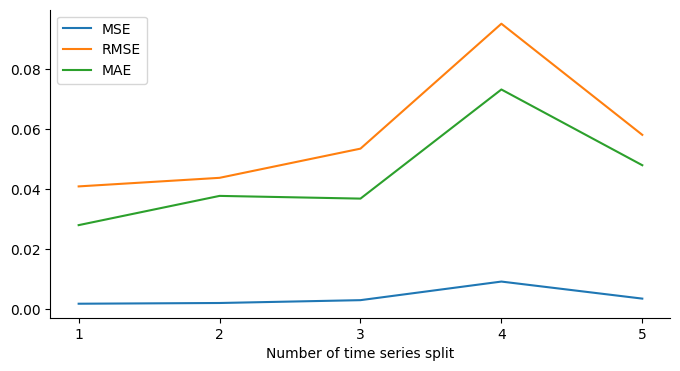

In [ ]:
# @title MSE

from matplotlib import pyplot as plt
eval_data[['MSE', 'RMSE',	'MAE']].plot(kind='line', figsize=(8, 4))
plt.xticks([1,2,3,4,5])
plt.xlabel('Number of time series split')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

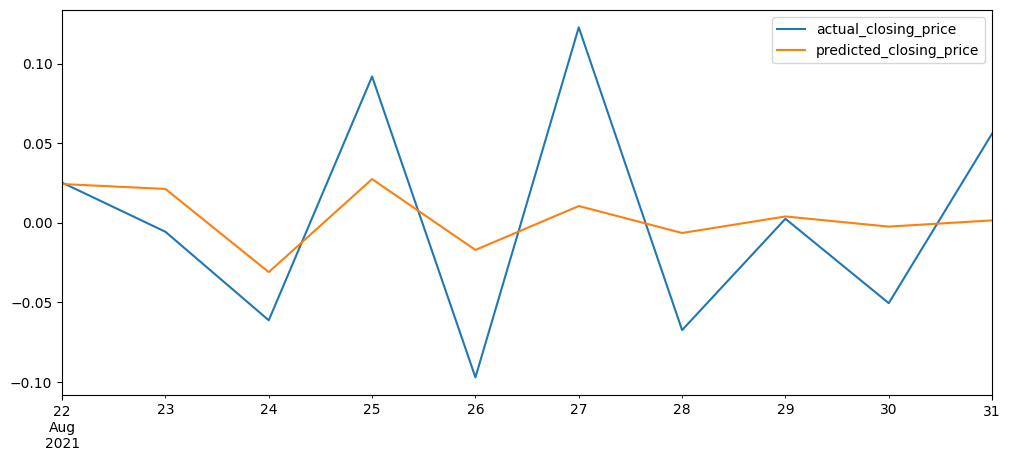

In [ ]:
    model = VARMAX(endog = ar_df[:-10], order= (1, 4))
    fitted_model = model.fit(disp=False)

    # Make predictions
    predictions = fitted_model.forecast(10)
    predictions.columns=['price_predicted','score_predicted']
    test_vs_pred=pd.concat([ar_df['price_diff'][-10:],predictions['price_predicted']],axis=1)
    test_vs_pred.columns = ['actual_closing_price',	'predicted_closing_price'	]
    test_vs_pred_price = test_vs_pred[['actual_closing_price',	'predicted_closing_price'	]]
    test_vs_pred_price.plot(figsize=(12,5))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random

params_evaluated= []
model = ARIMA(ar_df['price_diff'][:-10], order=(1, 1, 1))
results = model.fit()
predictions = results.forecast(10).to_frame()

MSE = mean_squared_error(ar_df['price_diff'][-10:], predictions['predicted_mean'])
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(ar_df['price_diff'][-10:], predictions['predicted_mean'])
MAPE = mean_absolute_percentage_error(ar_df['price_diff'][-10:], predictions['predicted_mean'])
params_evaluated.append({'mse': MSE, 'rmse': RMSE, 'mae': MAE, 'mape': MAPE})

<Axes: >

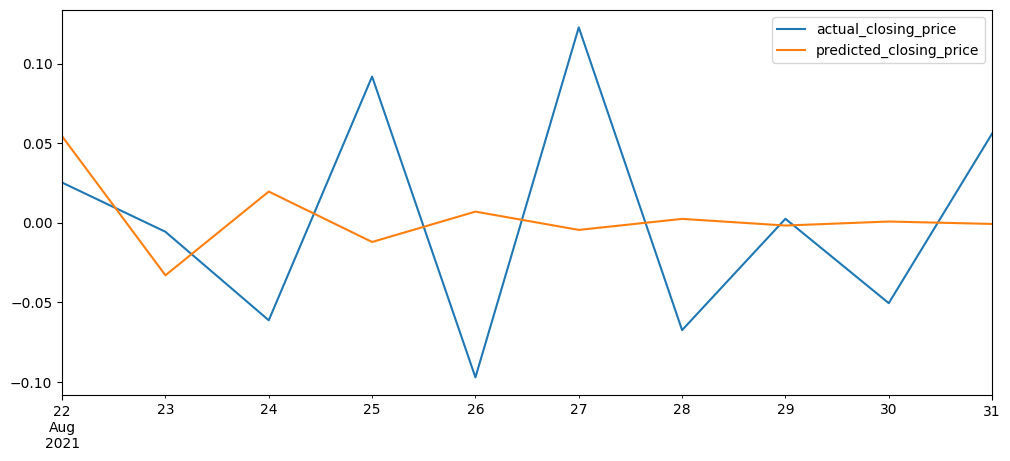

In [ ]:
test_vs_pred=pd.concat([ar_df['price_diff'][-10:],predictions['predicted_mean']],axis=1)
test_vs_pred.columns = ['actual_closing_price',	'predicted_closing_price'	]
test_vs_pred_price = test_vs_pred[['actual_closing_price',	'predicted_closing_price'	]]
test_vs_pred_price.plot(figsize=(12,5))

In [ ]:
eval_metrics = pd.DataFrame(list(params_evaluated))
eval_metrics

,mse,rmse,mae,mape
0,0.00567,0.07530,0.06547,1.52868


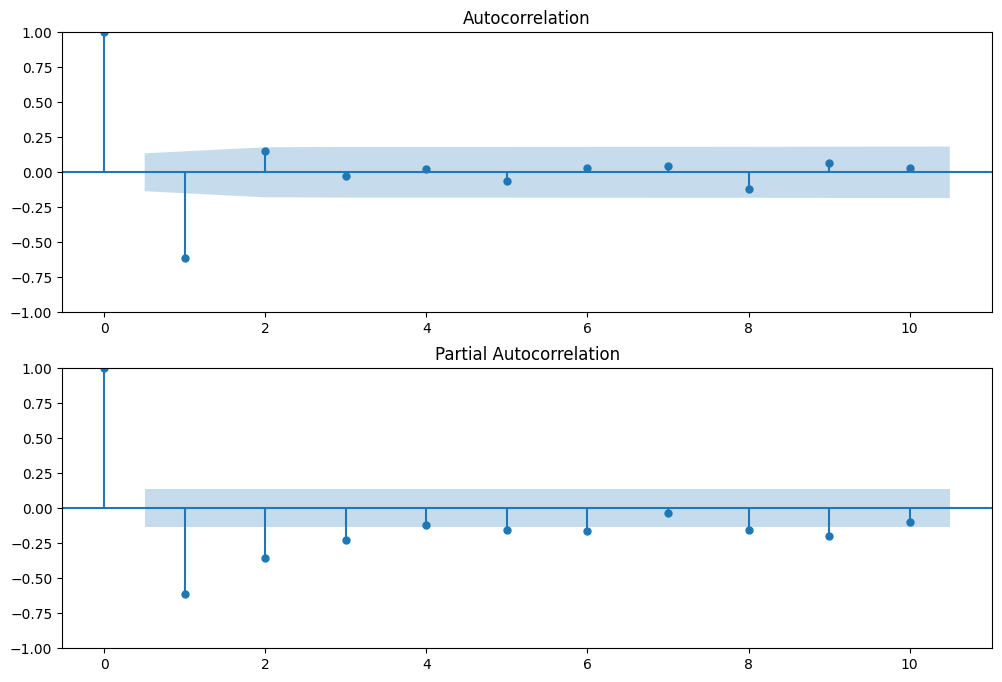

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ar_df['price_diff'].dropna(),lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ar_df['price_diff'].dropna(),lags=10,ax=ax2)